## Features+Head Starter - train

https://www.kaggle.com/code/nartaa/features-head-starter/notebook

Ensembleは行わない

### Configration

In [1]:
# モジュールの動的import(import先のファイルが更新されたときに追従する)
%load_ext autoreload
%autoreload 2

In [2]:
import os, gc

import numpy as np
import polars as pl
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt

print("TensorFlow version =", tf.__version__)

2024-03-22 01:05:29.663940: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-22 01:05:29.685755: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TensorFlow version = 2.12.0


In [3]:
# USE MULTIPLE GPUS
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)<=1:
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

Using 1 GPU


2024-03-22 01:05:31.083287: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-22 01:05:31.111569: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-22 01:05:31.111652: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
from src.cfg.v2 import CFG

In [5]:
# 自動混合精度の設定
# https://cocoinit23.com/tensowflow-automatic-mixed-precision/
if CFG.MIX:
  tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
  print("Mixed precision enabled")
else:
  print("Using full precision")

Mixed precision enabled


In [6]:
TARGETS = ["seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote"]
META = ["spectrogram_id", "spectrogram_label_offset_seconds", "patient_id", "expert_consensus"]

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]
FEATS2 = ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']

### Load and create Non-Overlapping eeg_id train csv

In [7]:
def add_kl(df):
    labels = df[TARGETS].values + 1e-5
    df["kl"] = tf.keras.losses.KLDivergence(reduction="none")(np.array([[1/6]*6]*len(df)), labels)

    return df

train_df = pd.read_csv(os.path.join(CFG.BASE_PATH, "train.csv"))

train_df = train_df.groupby("eeg_id")[META+TARGETS].agg({**{m: "first" for m in META}, **{t: "sum" for t in TARGETS}}).reset_index()
# TARGETSを割合とする
train_df[TARGETS] = train_df[TARGETS]/train_df[TARGETS].values.sum(axis=1, keepdims=True)
train_df.columns = ["eeg_id", "spec_id", "offset", "patient_id", "target"] + TARGETS

train_df = add_kl(train_df)

print("Train shape: ", train_df.shape)
train_df.head()

Train shape:  (17089, 12)


,eeg_id,spec_id,offset,patient_id,target,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,kl
0,568657,789577333,0.0,20654,Other,0.0,0.000000,0.25,0.000000,0.166667,0.583333,4.584192
1,582999,1552638400,0.0,20230,LPD,0.0,0.857143,0.00,0.071429,0.000000,0.071429,4.870032
2,642382,14960202,1008.0,5955,Other,0.0,0.000000,0.00,0.000000,0.000000,1.000000,7.802345
3,751790,618728447,908.0,38549,GPD,0.0,0.000000,1.00,0.000000,0.000000,0.000000,7.802345
4,778705,52296320,0.0,40955,Other,0.0,0.000000,0.00,0.000000,0.000000,1.000000,7.802345


### Load train spectrograms and eegs

In [8]:
def transform_eeg(eeg: np.ndarray) -> np.ndarray:
    rows = len(eeg)
    offset = (rows-10_000) // 2
    eeg = eeg.iloc[offset:offset+10_000]

    data = np.zeros((10_000, len(FEATS2)))
    for i, col in enumerate(FEATS2):
        # FILL NaN
        x = eeg[col].values.astype("float32")
        m = np.nanmean(x)
        if np.isnan(x).mean() < 1:
            x = np.nan_to_num(x, nan=m)
        else:
            x[:] = 0


        data[:, i] = x

    return data

In [9]:
%%time
specs = {}
eegs = {}
raw_eegs = {}
if CFG.TEST_MODE:
  train_df = train_df.sample(500, random_state=42).reset_index(drop=True)

  for i, v in enumerate(train_df["spec_id"].values):
    if i % 100 == 0:
      print(i, ", ", end="")
    specs[v] = pd.read_parquet(os.path.join(CFG.BASE_PATH, "train_spectrograms", f"{v}.parquet")).values

  for i, v in enumerate(train_df["eeg_id"].values):
    if i % 100 == 0:
      print(i, ", ", end="")
    eegs[v] = np.load(os.path.join("/kaggle/input", "brain-eeg-spectrograms", "{v}.npy"))

  for i, v in enumerate(train_df["eeg_id"].values):
    if i % 100 == 0:
      print(i, ", ", end="")
    eeg = np.load(os.path.join(CFG.BASE_PATH, "train_eegs", f"{v}.parquet"))
    raw_eegs[v] = transform_eeg(eeg)

else:
  # forを使わず一括で取得する via 公開Dataset
  specs = np.load("/kaggle/input/brain-spectrograms/specs.npy", allow_pickle=True).item()
  eegs = np.load("/kaggle/input/narata-brain-eeg-spectrograms/eeg_specs.npy", allow_pickle=True).item()
  raw_eegs = np.load("/kaggle/input/brain-eeg/eegs_processed.npy", allow_pickle=True).item()

CPU times: user 109 ms, sys: 4.67 s, total: 4.78 s
Wall time: 5.58 s


### DataLoader

In [10]:
! pip install -U albumentations

In [11]:
from src.loaders.dataloader import DataLoader

train_loader = DataLoader(
  df=train_df,
  specs=specs,
  eegs=eegs,
  augment=True,
)

In [12]:
train_loader.__getitem__(0)

(array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], dtype=float32),
 array([0. , 0. , 0.5, 0. , 0. , 0.5], d

In [14]:
# # dataloaderのスペクトログラム画像を表示

# ROWS = 2
# COLS = 3
# BATCHES = 2

# for i, (X, y) in enumerate(train_loader):
#   plt.figure(figsize=(20,8))
#   for j in range(ROWS):
#     for k in range(COLS):
#       plt.subplot(ROWS, COLS, j*COLS+k+1)

#       img = X[j*COLS+k, :, :, 0][::-1,]

#       min_value = img.flatten().min()
#       max_value = img.flatten().max()
#       img = (img-max_value) / (max_value-min_value)

#       plt.imshow(img)

#       y_s= y[j*COLS+k]

#       y_texts = f"[{y_s[0]:0.2f}"
#       for v in y_s[1:]:
#         y_texts += f", {v:0.2f}"

#       eeg = processed_train_df["eeg_id"].values[i*32+j*COLS+k]

#       plt.title(f"EEG = {eeg}\n y = {y_s}", size=12)
#       plt.yticks([])
#       plt.ylabel("Frequencies (Hz)", size=14)
#       plt.xlabel("Time (sec)", size=16)

#   plt.show()

#   if i == (BATCHES -1):
#     break




In [15]:
del train_loader
gc.collect()

3373

### Train scheduler

- StepTrainScheduleで最初の4epochを学習
- LR = 1e-3 (1, 2epoch) -> 1e-4 (3epoch) -> 1e-5 (4epoch)

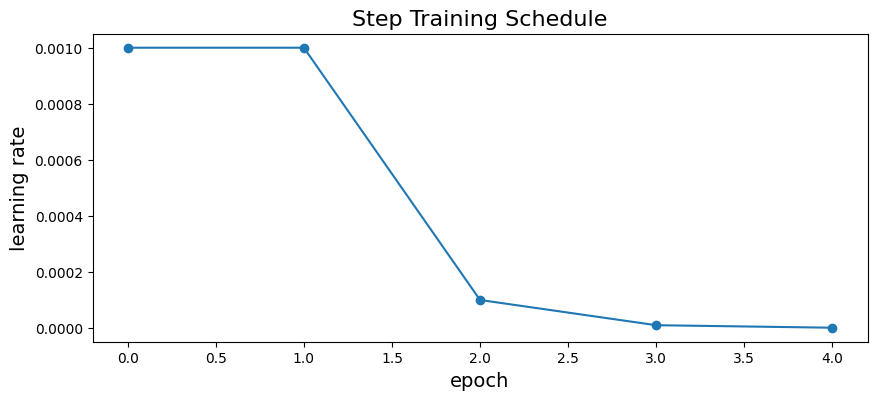

In [16]:
import math

def lrfn(epoch):
  if epoch < CFG.LR_RAMPUP_EPOCHS:
    lr = (CFG.LR_MAX - CFG.LR_START) / CFG.LR_RAMPUP_EPOCHS * epoch + CFG.LR_START
  elif epoch < (CFG.LR_RAMPUP_EPOCHS + CFG.LR_SUSTAIN_EPOCHS):
    lr = CFG.LR_MAX
  else:
    lr = CFG.LR_MAX * CFG.LR_STEP_DECAY ** ((epoch - CFG.LR_RAMPUP_EPOCHS - CFG.LR_SUSTAIN_EPOCHS) // CFG.EVERY)

  return lr

rng = [i for i in range(CFG.EPOCHS)]
y = [lrfn(x) for x in rng]

plt.figure(figsize=(10, 4))
plt.plot(rng, y, 'o-')
plt.xlabel("epoch", size=14)
plt.ylabel("learning rate", size=14)
plt.title("Step Training Schedule", size=16)
plt.show()

def lrfn2(epoch):
  return [1e-5, 1e-5, 1e-6][epoch]

LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)
LR2 = tf.keras.callbacks.LearningRateScheduler(lrfn2, verbose=True)

In [17]:
! pip install --no-index --find-links=/kaggle/input/tf-efficientnet-whl-files /kaggle/input/tf-efficientnet-whl-files/efficientnet-1.1.1-py3-none-any.whl

Looking in links: /kaggle/input/tf-efficientnet-whl-files
Processing /kaggle/input/tf-efficientnet-whl-files/efficientnet-1.1.1-py3-none-any.whl
efficientnet is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


### Transfer Learning

In [19]:
from sklearn.model_selection import KFold, GroupKFold
import tensorflow.keras.backend as K, gc

from src.models.efficientnet_b0 import EfficientNetB0

losses = []
val_losses = []
total_hist = {}
all_oof = []
all_true = []

gkf = GroupKFold(n_splits=5)
for i, (train_ix, valid_ix) in enumerate(gkf.split(train_df, train_df["target"], train_df["patient_id"])):
  print(f"Fold {i+1}")

  inp = tf.TensorSpec(shape=(512, 512, 3), dtype=tf.float32)
  output_signature = (inp, tf.TensorSpec(shape=(6,), dtype=tf.float32))

  transfer_train_df = train_df.iloc[train_ix]

  train_loader = DataLoader(
    df=transfer_train_df,
    specs=specs,
    eegs=eegs,
    augment=True,
  )
  train_dataset = tf.data.Dataset.from_generator(generator=train_loader, output_signature=output_signature).batch(CFG.BATCH_SIZE)

  valid_loader = DataLoader(
    df=train_df.iloc[valid_ix],
    specs=specs,
    eegs=eegs,
    augment=False,
    mode="valid",
  )
  valid_dataset = tf.data.Dataset.from_generator(generator=valid_loader, output_signature=output_signature).batch(CFG.BATCH_SIZE)

  # transfer learning
  transfer_train_df = transfer_train_df[transfer_train_df["kl"] < 5.5]

  train_loader2 = DataLoader(
    df=transfer_train_df,
    specs=specs,
    eegs=eegs,
    augment=True,
  )
  train_dataset2 = tf.data.Dataset.from_generator(generator=train_loader2, output_signature=output_signature).batch(CFG.BATCH_SIZE)

  K.clear_session()

  with strategy.scope():
    model = EfficientNetB0.build_model()

  if CFG.LOAD_MODELS_FROM_TRAIN == "":
    print(f"first stage train size {3*len(train_ix)}, valid size {3*len(valid_ix)}")
    history = model.fit(
      train_dataset,
      verbose=1,
      validation_data=valid_dataset,
      epochs=CFG.EPOCHS,
      callbacks=[LR],
    )

    print(f"second stage train size {3*len(transfer_train_df)}, valid size {3*len(valid_ix)}")
    history2 = model.fit(
      train_dataset2,
      verbose=1,
      validation_data=valid_dataset,
      epochs=CFG.EPOCHS2,
      callbacks=[LR2],
    )

    losses.append(history.history["loss"] + history2.history["loss"])
    val_losses.append(history.history["val_loss"] + history2.history["val_loss"])

    model.save_weights(f"/kaggle/output/EfficientNet_v{CFG.VER}_f{i}.h5")
  else:
    model.load_weights(f"{CFG.LOAD_MODELS_FROM_TRAIN}/Efficient_v{CFG.VER}_f{i}.h5")

  pred = model.predict(valid_dataset, verbose=1)
  pred = (pred[:len(valid_ix)] + pred[len(valid_ix): len(valid_ix)*2] + pred[len(valid_ix)*2:])/3

  oof = pred

  all_oof.append(oof)
  all_true.append(train_df.iloc[valid_ix][TARGETS].values)

  del model, oof
  gc.collect()

total_hist["loss"] = np.mean(losses, axis=0)
total_hist["val_loss"] = np.mean(val_losses, axis=0)
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

Fold 1
first stage train size 41013, valid size 10254

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5


2024-03-22 05:56:10.224403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 05:56:10.224705: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:880"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


   1282/Unknown - 296s 214ms/step - loss: 0.6854

2024-03-22 06:01:06.181178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 06:01:06.181476: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:883"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


1282/1282 [==============================] - 316s 230ms/step - loss: 0.6854 - val_loss: 0.8519 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/5


2024-03-22 06:01:26.455581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - ETA: 0s - loss: 0.5593

2024-03-22 06:06:01.012868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 06:06:01.040165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - 297s 232ms/step - loss: 0.5593 - val_loss: 1.1635 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/5


2024-03-22 06:06:23.472132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - ETA: 0s - loss: 0.4342

2024-03-22 06:10:58.040859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 06:10:58.067104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - 297s 232ms/step - loss: 0.4342 - val_loss: 0.7014 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
Epoch 4/5


2024-03-22 06:11:20.655961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - ETA: 0s - loss: 0.3887

2024-03-22 06:15:55.202634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 06:15:55.228700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - 297s 232ms/step - loss: 0.3887 - val_loss: 0.7457 - lr: 1.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.0000000000000002e-06.
Epoch 5/5


2024-03-22 06:16:17.646699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - ETA: 0s - loss: 0.3791

2024-03-22 06:20:52.233991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 06:20:52.260474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - 295s 230ms/step - loss: 0.3791 - val_loss: 0.7549 - lr: 1.0000e-06
second stage train size 8475, valid size 10254

Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/3


2024-03-22 06:21:13.071951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 06:21:13.073011: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:886"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


    265/Unknown - 57s 214ms/step - loss: 0.3917

2024-03-22 06:22:09.972570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 06:22:09.972931: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:883"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


265/265 [==============================] - 79s 297ms/step - loss: 0.3917 - val_loss: 0.7487 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1e-05.
Epoch 2/3


2024-03-22 06:22:31.912322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


265/265 [==============================] - ETA: 0s - loss: 0.3352

2024-03-22 06:23:28.844799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 06:23:28.872223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


265/265 [==============================] - 79s 297ms/step - loss: 0.3352 - val_loss: 0.7229 - lr: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1e-06.
Epoch 3/3


2024-03-22 06:23:50.795652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


265/265 [==============================] - ETA: 0s - loss: 0.3267

2024-03-22 06:24:47.626207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 06:24:47.651967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


265/265 [==============================] - 78s 296ms/step - loss: 0.3267 - val_loss: 0.7203 - lr: 1.0000e-06


2024-03-22 06:25:09.419767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 06:25:09.420082: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:883"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


321/321 [==============================] - 18s 52ms/step
Fold 2
first stage train size 41013, valid size 10254

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5


2024-03-22 06:25:29.347059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 06:25:29.347403: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022TensorDataset:1056"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {

   1282/Unknown - 296s 214ms/step - loss: 0.6865

2024-03-22 06:30:25.297444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 06:30:25.297776: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022TensorDataset:1059"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {

1282/1282 [==============================] - 320s 233ms/step - loss: 0.6865 - val_loss: 0.7727 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/5


2024-03-22 06:30:49.248361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - ETA: 0s - loss: 0.5565

2024-03-22 06:35:24.090898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 06:35:24.117567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - 300s 234ms/step - loss: 0.5565 - val_loss: 0.8045 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/5


2024-03-22 06:35:48.988737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - ETA: 0s - loss: 0.4240

2024-03-22 06:40:23.756905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 06:40:23.784293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - 296s 231ms/step - loss: 0.4240 - val_loss: 0.6243 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
Epoch 4/5


2024-03-22 06:40:45.063917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - ETA: 0s - loss: 0.3785

2024-03-22 06:45:19.703040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 06:45:19.731578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - 301s 234ms/step - loss: 0.3785 - val_loss: 0.6259 - lr: 1.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.0000000000000002e-06.
Epoch 5/5


2024-03-22 06:45:45.904767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - ETA: 0s - loss: 0.3727

2024-03-22 06:50:20.543260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 06:50:20.572301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - 297s 231ms/step - loss: 0.3727 - val_loss: 0.6269 - lr: 1.0000e-06
second stage train size 8880, valid size 10254

Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/3


2024-03-22 06:50:42.767752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 06:50:42.768728: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022TensorDataset:1062"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {

    278/Unknown - 60s 214ms/step - loss: 0.3781

2024-03-22 06:51:42.424845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 06:51:42.425222: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022TensorDataset:1059"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {

278/278 [==============================] - 82s 296ms/step - loss: 0.3781 - val_loss: 0.6260 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1e-05.
Epoch 2/3


2024-03-22 06:52:05.140871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


278/278 [==============================] - ETA: 0s - loss: 0.3215

2024-03-22 06:53:04.732892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 06:53:04.759359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


278/278 [==============================] - 84s 301ms/step - loss: 0.3215 - val_loss: 0.6230 - lr: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1e-06.
Epoch 3/3


2024-03-22 06:53:28.848869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


278/278 [==============================] - ETA: 0s - loss: 0.3134

2024-03-22 06:54:28.384065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 06:54:28.410962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


278/278 [==============================] - 84s 302ms/step - loss: 0.3134 - val_loss: 0.6211 - lr: 1.0000e-06


2024-03-22 06:54:53.160251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 06:54:53.160594: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022TensorDataset:1059"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {

321/321 [==============================] - 17s 52ms/step
Fold 3
first stage train size 41013, valid size 10254

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5


2024-03-22 06:55:12.954764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 06:55:12.955066: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022TensorDataset:1232"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {

   1282/Unknown - 295s 214ms/step - loss: 0.6771

2024-03-22 07:00:08.494970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 07:00:08.495283: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022TensorDataset:1235"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {

1282/1282 [==============================] - 320s 233ms/step - loss: 0.6771 - val_loss: 0.9062 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/5


2024-03-22 07:00:33.443765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - ETA: 0s - loss: 0.5443

2024-03-22 07:05:07.643008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 07:05:07.669524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - 297s 232ms/step - loss: 0.5443 - val_loss: 0.8028 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/5


2024-03-22 07:05:30.763010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - ETA: 0s - loss: 0.4142

2024-03-22 07:10:05.147119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 07:10:05.173297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - 297s 231ms/step - loss: 0.4142 - val_loss: 0.6618 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
Epoch 4/5


2024-03-22 07:10:27.330608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - ETA: 0s - loss: 0.3688

2024-03-22 07:15:01.793078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 07:15:01.819135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - 297s 232ms/step - loss: 0.3688 - val_loss: 0.6498 - lr: 1.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.0000000000000002e-06.
Epoch 5/5


2024-03-22 07:15:24.641353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - ETA: 0s - loss: 0.3635

2024-03-22 07:19:58.975393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 07:19:59.003288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - 297s 232ms/step - loss: 0.3635 - val_loss: 0.6520 - lr: 1.0000e-06
second stage train size 9135, valid size 10254

Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/3


2024-03-22 07:20:21.870042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 07:20:21.870938: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022TensorDataset:1238"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {

    286/Unknown - 61s 214ms/step - loss: 0.3708

2024-03-22 07:21:23.190649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 07:21:23.191049: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022TensorDataset:1235"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {

286/286 [==============================] - 85s 298ms/step - loss: 0.3708 - val_loss: 0.6565 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1e-05.
Epoch 2/3


2024-03-22 07:21:47.136895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


286/286 [==============================] - ETA: 0s - loss: 0.3181

2024-03-22 07:22:48.368281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 07:22:48.394347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


286/286 [==============================] - 84s 292ms/step - loss: 0.3181 - val_loss: 0.6450 - lr: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1e-06.
Epoch 3/3


2024-03-22 07:23:10.901053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


286/286 [==============================] - ETA: 0s - loss: 0.3078

2024-03-22 07:24:12.280474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 07:24:12.306898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


286/286 [==============================] - 81s 284ms/step - loss: 0.3078 - val_loss: 0.6480 - lr: 1.0000e-06


2024-03-22 07:24:32.560992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 07:24:32.561322: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022TensorDataset:1235"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {

321/321 [==============================] - 18s 52ms/step
Fold 4
first stage train size 41013, valid size 10254

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5


2024-03-22 07:24:52.523980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 07:24:52.524294: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022TensorDataset:1408"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {

   1282/Unknown - 295s 214ms/step - loss: 0.6728

2024-03-22 07:29:47.526780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 07:29:47.527109: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022TensorDataset:1411"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {

1282/1282 [==============================] - 318s 232ms/step - loss: 0.6728 - val_loss: 1.0510 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/5


2024-03-22 07:30:10.904026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - ETA: 0s - loss: 0.5385

2024-03-22 07:34:45.245384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 07:34:45.272240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - 296s 231ms/step - loss: 0.5385 - val_loss: 0.9282 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/5


2024-03-22 07:35:07.158393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - ETA: 0s - loss: 0.4087

2024-03-22 07:39:41.451509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 07:39:41.477913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - 297s 231ms/step - loss: 0.4087 - val_loss: 0.6481 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
Epoch 4/5


2024-03-22 07:40:03.860482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - ETA: 0s - loss: 0.3625

2024-03-22 07:44:38.083617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 07:44:38.109698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - 298s 232ms/step - loss: 0.3625 - val_loss: 0.6653 - lr: 1.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.0000000000000002e-06.
Epoch 5/5


2024-03-22 07:45:01.485105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - ETA: 0s - loss: 0.3567

2024-03-22 07:49:35.606290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 07:49:35.632628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - 296s 231ms/step - loss: 0.3567 - val_loss: 0.6719 - lr: 1.0000e-06
second stage train size 8874, valid size 10254

Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/3


2024-03-22 07:49:57.220863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 07:49:57.222462: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022TensorDataset:1414"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {

    278/Unknown - 60s 214ms/step - loss: 0.3778

2024-03-22 07:50:56.884384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 07:50:56.884744: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022TensorDataset:1411"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {

278/278 [==============================] - 80s 289ms/step - loss: 0.3778 - val_loss: 0.6430 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1e-05.
Epoch 2/3


2024-03-22 07:51:17.669187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


278/278 [==============================] - ETA: 0s - loss: 0.3162

2024-03-22 07:52:17.091441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 07:52:17.118535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


278/278 [==============================] - 82s 296ms/step - loss: 0.3162 - val_loss: 0.6345 - lr: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1e-06.
Epoch 3/3


2024-03-22 07:52:40.161296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


278/278 [==============================] - ETA: 0s - loss: 0.3069

2024-03-22 07:53:39.669073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 07:53:39.695203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


278/278 [==============================] - 80s 288ms/step - loss: 0.3069 - val_loss: 0.6323 - lr: 1.0000e-06


2024-03-22 07:54:00.440691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 07:54:00.441004: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022TensorDataset:1411"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {

321/321 [==============================] - 18s 52ms/step
Fold 5
first stage train size 41016, valid size 10251

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5


2024-03-22 07:54:20.369300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 07:54:20.369617: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022TensorDataset:1584"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {

   1282/Unknown - 295s 214ms/step - loss: 0.6860

2024-03-22 07:59:15.927977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 07:59:15.928286: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022TensorDataset:1587"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {

1282/1282 [==============================] - 319s 233ms/step - loss: 0.6860 - val_loss: 0.8552 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/5


2024-03-22 07:59:39.805466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - ETA: 0s - loss: 0.5579

2024-03-22 08:04:14.166114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 08:04:14.192930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - 299s 233ms/step - loss: 0.5579 - val_loss: 1.1246 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/5


2024-03-22 08:04:39.143471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - ETA: 0s - loss: 0.4273

2024-03-22 08:09:13.808088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 08:09:13.834450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - 298s 232ms/step - loss: 0.4273 - val_loss: 0.6212 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
Epoch 4/5


2024-03-22 08:09:37.178328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - ETA: 0s - loss: 0.3834

2024-03-22 08:14:11.942266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 08:14:11.968667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - 300s 233ms/step - loss: 0.3834 - val_loss: 0.6051 - lr: 1.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.0000000000000002e-06.
Epoch 5/5


2024-03-22 08:14:36.733221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - ETA: 0s - loss: 0.3749

2024-03-22 08:19:11.230722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 08:19:11.256585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1282/1282 [==============================] - 297s 231ms/step - loss: 0.3749 - val_loss: 0.6106 - lr: 1.0000e-06
second stage train size 8892, valid size 10251

Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/3


2024-03-22 08:19:33.688410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 08:19:33.689290: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022TensorDataset:1590"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {

    278/Unknown - 60s 214ms/step - loss: 0.3842

2024-03-22 08:20:33.375825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 08:20:33.376187: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022TensorDataset:1587"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {

278/278 [==============================] - 83s 298ms/step - loss: 0.3842 - val_loss: 0.6221 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1e-05.
Epoch 2/3


2024-03-22 08:20:56.829606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


278/278 [==============================] - ETA: 0s - loss: 0.3257

2024-03-22 08:21:56.474301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 08:21:56.505618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


278/278 [==============================] - 85s 305ms/step - loss: 0.3257 - val_loss: 0.6204 - lr: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1e-06.
Epoch 3/3


2024-03-22 08:22:21.612863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


278/278 [==============================] - ETA: 0s - loss: 0.3196

2024-03-22 08:23:21.266155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 08:23:21.291773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


278/278 [==============================] - 84s 301ms/step - loss: 0.3196 - val_loss: 0.6194 - lr: 1.0000e-06


2024-03-22 08:23:45.591264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 08:23:45.591586: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022TensorDataset:1587"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {

321/321 [==============================] - 18s 52ms/step


### CV score for EfficientNet

KL(=Kullback-Leibler) Divergenceによる性能評価
https://qiita.com/shuva/items/81ad2a337175c035988f

In [20]:
from src.metrics import kl_div

oof = pd.DataFrame(all_oof.copy())
oof["id"] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true["id"] = np.arange(len(true))

cv = kl_div.score(solution=true, submission=oof, row_id_column_name="id")

print("CV score KL-Div for EfficientNetB0=", cv)

CV score KL-Div for EfficientNetB0= 0.5904708373848311


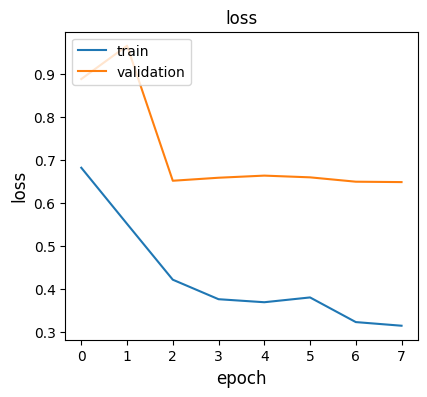

In [21]:
def plot_hist(hist):
    metrics = ['loss']
    for i,metric in enumerate(metrics):
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,i+1)
        plt.plot(hist[metric])
        plt.plot(hist[f'val_{metric}'])
        plt.title(f'{metric}',size=12)
        plt.ylabel(f'{metric}',size=12)
        plt.xlabel('epoch',size=12)
        plt.legend(["train", "validation"], loc="upper left")
        plt.show()

plot_hist(total_hist)

### Local Ensembel Testing on CV